##### Copyright 2020 The TensorFlow Quantum Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

[link text](https://)# Binary classification of quantum states

Initial Tutorial Author : Antonio J. Martinez

Initial Tutorial Contributors : Masoud Mohseni

Initial Tutorial Created : 2020-Feb-14

Initial Tutorial Last updated : 2020-Feb-29

---

Current Experiment Author : Anneliese Brei

Current Experiment Created : 2022-Jan-3

Current Experiment Last updated : 2022-Jan-3

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorflow/quantum/blob/research/binary_classifier/binary_classifier.ipynb)

An elementary learning task is [binary classification](https://en.wikipedia.org/wiki/Binary_classification), a supervised task in which the learner is to distinguish which of two classes a given datapoint has been drawn from.  Here, using ideas from the paper [Universal discriminative quantum neural networks](https://arxiv.org/abs/1805.08654) in the one-qubit setting, we train a hybrid quantum-classical neural network to distinguish between quantum data sources.

## Import dependencies

In [ ]:
!pip install --upgrade tensorflow
!pip install qutip

In [ ]:
!pip install tensorflow-quantum

In [ ]:
import cirq
import numpy as np
import qutip
import random
import sympy
import tensorflow as tf
import tensorflow_quantum as tfq

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## Quantum dataset
For our quantum dataset, you will generate two blobs on the surface of the Bloch sphere.  The task will be to learn a model to distinguish members of these blobs.  To do this, you first select two axes in the X-Z plane of the block sphere, then select random points uniformly distributed around them:

In [ ]:
def generate_dataset(qubit, theta_a, theta_b, num_samples):
  """Generate a dataset of points on `qubit` near the two given angles; labels
  for the two clusters use a one-hot encoding.
  """
  q_data = []
  bloch = {"a": [[], [], []], "b": [[], [], []]}
  labels = []
  blob_size = abs(theta_a - theta_b) / 5
  for _ in range(num_samples):
    coin = random.random()
    spread_x = np.random.uniform(-blob_size, blob_size)
    spread_y = np.random.uniform(-blob_size, blob_size)
    if coin < 0.5:
      label = [1, 0]
      angle = theta_a + spread_y
      source = "a"
    else:
      label = [0, 1]
      angle = theta_b + spread_y
      source = "b"
    labels.append(label)
    q_data.append(cirq.Circuit(cirq.ry(-angle)(qubit), cirq.rx(-spread_x)(qubit)))
    bloch[source][0].append(np.cos(angle))
    bloch[source][1].append(np.sin(angle)*np.sin(spread_x))
    bloch[source][2].append(np.sin(angle)*np.cos(spread_x))
  return tfq.convert_to_tensor(q_data), np.array(labels), bloch

In [ ]:
def build_model(theta_a, theta_b):

  qubit = cirq.GridQubit(0, 0)

  # Build the quantum model layer 1
  theta = sympy.Symbol('theta')
  q_model = cirq.Circuit(cirq.ry(theta)(qubit))
  q_data_input = tf.keras.Input(
      shape=(), dtype=tf.dtypes.string)
  expectation = tfq.layers.PQC(q_model, cirq.Z(qubit))
  expectation_output = expectation(q_data_input)

  # Attach the classical SoftMax classifier
  classifier = tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
  classifier_output = classifier(expectation_output)
  model = tf.keras.Model(inputs=q_data_input, outputs=classifier_output)

  # Standard compilation for classification
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])
  
  return model, qubit

In [ ]:
# Constants
theta_a = 1
theta_b = 4

num_samples = 500 # Number datapoints
iterations = 10
num_epochs = 10

## 1-Node Framework
Implement Binary Classification in a federated learning framework using 2 separate models run by 2 different simulators. Model 0 represents the global model. Model 1 is a client. The parameters are averaged and used to update the global model.

In [ ]:
def run_1_node():

  model0, qubit0 = build_model(theta_a, theta_b) # global
  model1, qubit1 = build_model(theta_a, theta_b) # client
    
  loss = []       # Loss value from each iteration
  accuracy = []   # Accuracy % of each iteration

  for round in range(iterations):

    # Generate new local data for client
    qubit = cirq.GridQubit(0, 0)
    q_data1, labels1, _ = generate_dataset(qubit, theta_a, theta_b, num_samples) 

    # Train client 1 with (all) local data
    history1 = model1.fit(x=q_data1, y=labels1, epochs=num_epochs, verbose=0)

    weights0 = model0.get_weights()   # Extract global weights (parameters)
    weights1 = model1.get_weights()   # Extract client weights (parameters)

    # Average weights
    avg_weights = weights0
    for j in range(len(weights0)):
      avg_weights[j] = (weights0[j] + weights1[j]) / 2
    #print("Averaged : \nMA :", avg_weights)  

    # Update weights
    model0.set_weights(avg_weights)
    model1.set_weights(avg_weights)

    # Test updated global model for metrics
    qubit = cirq.GridQubit(0, 0)
    test_data, test_labels, test_bloch_p = generate_dataset(qubit, theta_a, theta_b, 500)
    test_results = model0.evaluate(test_data,test_labels, verbose=0)

    loss.append(test_results[0])        # Save loss value of each round
    accuracy.append(test_results[1])    # Save accuracy of each round

  return loss, accuracy

## 2-Node Framework
Implement Binary Classification in a federated learning framework using 3 client nodes and the global node models run by 3 different simulators. Model 0 represents the global model. Models 1 and 2 are clients. The parameters are averaged and used to update the global model.

In [ ]:
def run_2_node():

  model0, qubit0 = build_model(theta_a, theta_b) #global
  model1, qubit1 = build_model(theta_a, theta_b) #client1
  model2, qubit2 = build_model(theta_a, theta_b) #client2

  loss = []       # Loss value from each iteration
  accuracy = []   # Accuracy % of each iteration

  for round in range(iterations):

    # Generate new local data for clients, D2 and D3
    qubit = cirq.GridQubit(0, 0)
    q_data1, labels1, bloch_p1 = generate_dataset(qubit1, theta_a, theta_b, num_samples) 
    q_data2, labels2, bloch_p2 = generate_dataset(qubit2, theta_a, theta_b, num_samples)

    # Train clients with local data
    history1 = model1.fit(x=q_data1, y=labels1, epochs=num_epochs, verbose=0)
    history2 = model2.fit(x=q_data2, y=labels2, epochs=num_epochs, verbose=0)

    weights0 = model0.get_weights()   # Extract global weights (parameters)
    weights1 = model1.get_weights()   # Extract client weights (parameters)
    weights2 = model2.get_weights()   # Extract client weights (parameters)

    # Average weights
    avg_weights = weights0
    for j in range(len(weights0)):
      avg_weights[j] = (weights0[j] + weights1[j] + weights2[j]) / 3 

    # Update weights
    model0.set_weights(avg_weights)
    model1.set_weights(avg_weights)
    model2.set_weights(avg_weights)

    # Test updated global model for metrics
    qubit = cirq.GridQubit(0, 0)
    test_data, test_labels, test_bloch_p = generate_dataset(qubit, theta_a, theta_b, 500)
    test_results = model0.evaluate(test_data,test_labels, verbose=0)

    loss.append(test_results[0])        # Save loss value of each round
    accuracy.append(test_results[1])    # Save accuracy of each round

  return loss, accuracy

## 5-Node Framework
Implement Binary Classification in a federated learning framework using 5 separate models run by 5 different simulators. Model 0 represents the global model. Models 1, 2, 3, 4 are clients. The parameters are averaged and used to update the global model.

In [ ]:
def run_5_node():
    
  model0, _ = build_model(theta_a, theta_b) #global
  model1, _ = build_model(theta_a, theta_b) #client 1
  model2, _ = build_model(theta_a, theta_b) #client 2
  model3, _ = build_model(theta_a, theta_b) #client 3
  model4, _ = build_model(theta_a, theta_b) #client 4
  model5, _ = build_model(theta_a, theta_b) #client 5

  loss = []       # Loss value from each iteration
  accuracy = []   # Accuracy % of each iteration

  for round in range(iterations):

    # Generate new local data for clients, D1, D2, D3, D4
    qubit = cirq.GridQubit(0, 0)
    q_data1, labels1, bloch_p1 = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data2, labels2, bloch_p2 = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data3, labels3, bloch_p3 = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data4, labels4, bloch_p4 = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data5, labels5, bloch_p5 = generate_dataset(qubit, theta_a, theta_b, num_samples) 

    # Train clients with local data
    history1 = model1.fit(x=q_data1, y=labels1, epochs=num_epochs, verbose=0)
    history2 = model2.fit(x=q_data2, y=labels2, epochs=num_epochs, verbose=0)
    history3 = model3.fit(x=q_data3, y=labels3, epochs=num_epochs, verbose=0)
    history4 = model4.fit(x=q_data4, y=labels4, epochs=num_epochs, verbose=0)
    history5 = model5.fit(x=q_data5, y=labels5, epochs=num_epochs, verbose=0)

    weights0 = model0.get_weights()   # Extract global weights (parameters)
    weights1 = model1.get_weights()   # Extract client weights (parameters)
    weights2 = model2.get_weights()   # Extract client weights (parameters)
    weights3 = model3.get_weights()   # Extract client weights (parameters)
    weights4 = model4.get_weights()   # Extract client weights (parameters)
    weights5 = model5.get_weights()   # Extract client weights (parameters)

    # Average weights
    avg_weights = weights0
    for j in range(len(weights0)):
      avg_weights[j] = (weights0[j] + weights1[j] + weights2[j] + weights3[j] + weights4[j] + weights5[j]) / 6

    # Update weights
    model0.set_weights(avg_weights)
    model1.set_weights(avg_weights)
    model2.set_weights(avg_weights)
    model3.set_weights(avg_weights)
    model4.set_weights(avg_weights)
    model5.set_weights(avg_weights)

    # Test updated global model for metrics
    qubit = cirq.GridQubit(0, 0)
    test_data, test_labels, test_bloch_p = generate_dataset(qubit, theta_a, theta_b, 500)
    test_results = model0.evaluate(test_data,test_labels, verbose=0)

    loss.append(test_results[0])        # Save loss value of each round
    accuracy.append(test_results[1])    # Save accuracy of each round

  return loss, accuracy

## 10-Node Framework
Implement Binary Classification in a federated learning framework using 10 clients. Model 0 represents the global model. Models 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 are clients. The parameters are averaged and used to update the global model.

In [ ]:
def run_10_node():

  # Create 10-node framework: 1 global model, 10 clients
  model0, _ = build_model(theta_a, theta_b) #global
  model1, _ = build_model(theta_a, theta_b)
  model2, _ = build_model(theta_a, theta_b)
  model3, _ = build_model(theta_a, theta_b)
  model4, _ = build_model(theta_a, theta_b)
  model5, _ = build_model(theta_a, theta_b)
  model6, _ = build_model(theta_a, theta_b)
  model7, _ = build_model(theta_a, theta_b)
  model8, _ = build_model(theta_a, theta_b)
  model9, _ = build_model(theta_a, theta_b)
  model10, _ = build_model(theta_a, theta_b)

  loss = []       # Loss value from each epoch
  accuracy = []   # Accuracy % of each epoch

  for round in range(iterations):

    # Generate new local data for clients, D1, D2, D3, D4
    qubit = cirq.GridQubit(0, 0)
    q_data1, labels1, bloch_p1 = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data2, labels2, bloch_p2 = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data3, labels3, bloch_p3 = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data4, labels4, bloch_p4 = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data5, labels5, bloch_p5 = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data6, labels6, bloch_p6 = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data7, labels7, bloch_p7 = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data8, labels8, bloch_p8 = generate_dataset(qubit, theta_a, theta_b, num_samples)
    q_data9, labels9, bloch_p9 = generate_dataset(qubit, theta_a, theta_b, num_samples)
    q_data10, labels10, bloch_p10 = generate_dataset(qubit, theta_a, theta_b, num_samples)

    # Train clients with local data
    history1 = model1.fit(x=q_data1, y=labels1, epochs=num_epochs, verbose=0)
    history2 = model2.fit(x=q_data2, y=labels2, epochs=num_epochs, verbose=0)
    history3 = model3.fit(x=q_data3, y=labels3, epochs=num_epochs, verbose=0)
    history4 = model4.fit(x=q_data4, y=labels4, epochs=num_epochs, verbose=0)
    history5 = model5.fit(x=q_data5, y=labels5, epochs=num_epochs, verbose=0)
    history6 = model6.fit(x=q_data6, y=labels6, epochs=num_epochs, verbose=0)
    history7 = model7.fit(x=q_data7, y=labels7, epochs=num_epochs, verbose=0)
    history8 = model8.fit(x=q_data8, y=labels8, epochs=num_epochs, verbose=0)
    history9 = model9.fit(x=q_data9, y=labels9, epochs=num_epochs, verbose=0)
    history10 = model10.fit(x=q_data10, y=labels10, epochs=num_epochs, verbose=0)

    weights0 = model0.get_weights()   # Extract global weights (parameters)
    weights1 = model1.get_weights()   # Extract client weights (parameters)
    weights2 = model2.get_weights()   # Extract client weights (parameters)
    weights3 = model3.get_weights()   # Extract client weights (parameters)
    weights4 = model4.get_weights()   # Extract client weights (parameters)
    weights5 = model5.get_weights()   # Extract global weights (parameters)
    weights6 = model6.get_weights()   # Extract client weights (parameters)
    weights7 = model7.get_weights()   # Extract client weights (parameters)
    weights8 = model8.get_weights()   # Extract client weights (parameters)
    weights9 = model9.get_weights()   # Extract client weights (parameters)
    weights10 = model10.get_weights()   # Extract client weights (parameters)

    # Average weights
    avg_weights = weights0
    for j in range(len(weights0)):
      avg_weights[j] = (weights0[j] + weights1[j] + weights2[j] + weights3[j] 
                        + weights4[j] + weights5[j] + weights6[j] + weights7[j] 
                        + weights8[j] + weights9[j] + weights10[j]) / 11

    # Update weights
    model0.set_weights(avg_weights)
    model1.set_weights(avg_weights)
    model2.set_weights(avg_weights)
    model3.set_weights(avg_weights)
    model4.set_weights(avg_weights)
    model5.set_weights(avg_weights)
    model6.set_weights(avg_weights)
    model7.set_weights(avg_weights)
    model8.set_weights(avg_weights)
    model9.set_weights(avg_weights)
    model10.set_weights(avg_weights)

    # Test updated global model for metrics
    qubit = cirq.GridQubit(0, 0)
    test_data, test_labels, test_bloch_p = generate_dataset(qubit, theta_a, theta_b, 500)
    test_results = model0.evaluate(test_data,test_labels, verbose=0)

    loss.append(test_results[0])        # Save loss value of each round
    accuracy.append(test_results[1])    # Save accuracy of each round

  return loss, accuracy

## Run frameworks

## 20-Node Framework
Implement Binary Classification in a federated learning framework using 20 clients. Model 0 represents the global model. Models 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20 are clients. The parameters are averaged and used to update the global model.

In [ ]:
def run_20_node():
    
  model0, _ = build_model(theta_a, theta_b) #global
  model1, _ = build_model(theta_a, theta_b)
  model2, _ = build_model(theta_a, theta_b)
  model3, _ = build_model(theta_a, theta_b)
  model4, _ = build_model(theta_a, theta_b)
  model5, _ = build_model(theta_a, theta_b)
  model6, _ = build_model(theta_a, theta_b)
  model7, _ = build_model(theta_a, theta_b)
  model8, _ = build_model(theta_a, theta_b)
  model9, _ = build_model(theta_a, theta_b)
  model10, _ = build_model(theta_a, theta_b)
  model11, _ = build_model(theta_a, theta_b)
  model12, _ = build_model(theta_a, theta_b)
  model13, _ = build_model(theta_a, theta_b)
  model14, _ = build_model(theta_a, theta_b)
  model15, _ = build_model(theta_a, theta_b)
  model16, _ = build_model(theta_a, theta_b)
  model17, _ = build_model(theta_a, theta_b)
  model18, _ = build_model(theta_a, theta_b)
  model19, _ = build_model(theta_a, theta_b)
  model20, _ = build_model(theta_a, theta_b)

  loss = []       # Loss value from each epoch
  accuracy = []   # Accuracy % of each epoch

  for round in range(iterations):

    # Generate new local data for clients, D1, D2, D3, D4
    qubit = cirq.GridQubit(0, 0)
    q_data1, labels1, _ = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data2, labels2, _ = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data3, labels3, _ = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data4, labels4, _ = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data5, labels5, _ = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data6, labels6, _ = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data7, labels7, _ = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data8, labels8, _ = generate_dataset(qubit, theta_a, theta_b, num_samples)
    q_data9, labels9, _ = generate_dataset(qubit, theta_a, theta_b, num_samples)
    q_data10, labels10, _ = generate_dataset(qubit, theta_a, theta_b, num_samples)
    q_data11, labels11, _ = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data12, labels12, _ = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data13, labels13, _ = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data14, labels14, _ = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data15, labels15, _ = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data16, labels16, _ = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data17, labels17, _ = generate_dataset(qubit, theta_a, theta_b, num_samples) 
    q_data18, labels18, _ = generate_dataset(qubit, theta_a, theta_b, num_samples)
    q_data19, labels19, _ = generate_dataset(qubit, theta_a, theta_b, num_samples)
    q_data20, labels20, _ = generate_dataset(qubit, theta_a, theta_b, num_samples)

    # Train clients with local data
    history1 = model1.fit(x=q_data1, y=labels1, epochs=num_epochs, verbose=0)
    history2 = model2.fit(x=q_data2, y=labels2, epochs=num_epochs, verbose=0)
    history3 = model3.fit(x=q_data3, y=labels3, epochs=num_epochs, verbose=0)
    history4 = model4.fit(x=q_data4, y=labels4, epochs=num_epochs, verbose=0)
    history5 = model5.fit(x=q_data5, y=labels5, epochs=num_epochs, verbose=0)
    history6 = model6.fit(x=q_data6, y=labels6, epochs=num_epochs, verbose=0)
    history7 = model7.fit(x=q_data7, y=labels7, epochs=num_epochs, verbose=0)
    history8 = model8.fit(x=q_data8, y=labels8, epochs=num_epochs, verbose=0)
    history9 = model9.fit(x=q_data9, y=labels9, epochs=num_epochs, verbose=0)
    history10 = model10.fit(x=q_data10, y=labels10, epochs=num_epochs, verbose=0)
    history11 = model11.fit(x=q_data11, y=labels11, epochs=num_epochs, verbose=0)
    history12 = model12.fit(x=q_data12, y=labels12, epochs=num_epochs, verbose=0)
    history13 = model13.fit(x=q_data13, y=labels13, epochs=num_epochs, verbose=0)
    history14 = model14.fit(x=q_data14, y=labels14, epochs=num_epochs, verbose=0)
    history15 = model15.fit(x=q_data15, y=labels15, epochs=num_epochs, verbose=0)
    history16 = model16.fit(x=q_data16, y=labels16, epochs=num_epochs, verbose=0)
    history17 = model17.fit(x=q_data17, y=labels17, epochs=num_epochs, verbose=0)
    history18 = model18.fit(x=q_data18, y=labels18, epochs=num_epochs, verbose=0)
    history19 = model19.fit(x=q_data19, y=labels19, epochs=num_epochs, verbose=0)
    history20 = model20.fit(x=q_data20, y=labels20, epochs=num_epochs, verbose=0)

    # Extract global weights (parameters)
    weights0 = model0.get_weights()   
    weights1 = model1.get_weights()  
    weights2 = model2.get_weights()  
    weights3 = model3.get_weights()  
    weights4 = model4.get_weights()   
    weights5 = model5.get_weights() 
    weights6 = model6.get_weights()   
    weights7 = model7.get_weights()   
    weights8 = model8.get_weights()  
    weights9 = model9.get_weights()  
    weights10 = model10.get_weights()  
    weights11 = model11.get_weights()  
    weights12 = model12.get_weights()  
    weights13 = model13.get_weights()  
    weights14 = model14.get_weights()   
    weights15 = model15.get_weights() 
    weights16 = model16.get_weights()   
    weights17 = model17.get_weights()   
    weights18 = model18.get_weights()  
    weights19 = model19.get_weights()  
    weights20 = model20.get_weights()   

    # Average weights
    avg_weights = weights0
    for j in range(len(weights0)):
      avg_weights[j] = (weights0[j] + weights1[j] + weights2[j] + weights3[j] 
                        + weights4[j] + weights5[j] + weights6[j] + weights7[j] 
                        + weights8[j] + weights9[j] + weights10[j]
                        + weights11[j] + weights12[j] + weights13[j] 
                        + weights14[j] + weights15[j] + weights16[j] + weights17[j] 
                        + weights18[j] + weights19[j] + weights20[j]) / 21 

    # Update weights
    model0.set_weights(avg_weights)
    model1.set_weights(avg_weights)
    model2.set_weights(avg_weights)
    model3.set_weights(avg_weights)
    model4.set_weights(avg_weights)
    model5.set_weights(avg_weights)
    model6.set_weights(avg_weights)
    model7.set_weights(avg_weights)
    model8.set_weights(avg_weights)
    model9.set_weights(avg_weights)
    model10.set_weights(avg_weights)
    model11.set_weights(avg_weights)
    model12.set_weights(avg_weights)
    model13.set_weights(avg_weights)
    model14.set_weights(avg_weights)
    model15.set_weights(avg_weights)
    model16.set_weights(avg_weights)
    model17.set_weights(avg_weights)
    model18.set_weights(avg_weights)
    model19.set_weights(avg_weights)
    model20.set_weights(avg_weights)

    # Test updated global model for metrics
    qubit = cirq.GridQubit(0, 0)
    test_data, test_labels, test_bloch_p = generate_dataset(qubit, theta_a, theta_b, 500)
    test_results = model0.evaluate(test_data,test_labels, verbose=0)

    loss.append(test_results[0])        # Save loss value of each round
    accuracy.append(test_results[1])    # Save accuracy of each round

  return loss, accuracy

In [ ]:
loss1_1, accuracy1_1 = run_1_node()
loss1_2, accuracy1_2 = run_1_node()
loss1_3, accuracy1_3 = run_1_node()
loss1_4, accuracy1_4 = run_1_node()
loss1_5, accuracy1_5 = run_1_node()

In [ ]:
loss1 = []
accuracy1 = []

# Calculate average loss
for i in range(len(loss1_1)):
  loss1.append((loss1_1[i] + loss1_2[i] + loss1_3[i] + loss1_4[i] + loss1_5[i]) / 5)

print('loss1_1 :', loss1_1)
print('loss1_2 :', loss1_2)
print('loss1_3 :', loss1_3)
print('loss1_4 :', loss1_4)
print('loss1_5 :', loss1_5)
print('loss1 : ', loss1)


# Calculate average accuracy
for i in range(len(accuracy1_1)):
  accuracy1.append((accuracy1_1[i] + accuracy1_2[i] + accuracy1_3[i] + accuracy1_4[i] + accuracy1_5[i]) / 5)

print('accuracy1_1 :', accuracy1_1)
print('accuracy1_2 :', accuracy1_2)
print('accuracy1_3 :', accuracy1_3)
print('accuracy1_4 :', accuracy1_4)
print('accuracy1_5 :', accuracy1_5)
print('accuracy1 : ', accuracy1)

loss1_1 : [1.0467690229415894, 0.10749558359384537, 0.007754320278763771, 0.0019330157665535808, 0.000981668708845973, 0.0006399232079274952, 0.00044225051533430815, 0.0003371612401679158, 0.00029505250859074295, 0.00021385872969403863]
loss1_2 : [0.03386761620640755, 0.00403784541413188, 0.001266844803467393, 0.0005886185099370778, 0.0003580591583158821, 0.00022251874906942248, 0.0001668507029535249, 0.00013478832261171192, 0.00010747816122602671, 8.718220487935469e-05]
loss1_3 : [1.3700543642044067, 0.11040358245372772, 0.007542714476585388, 0.0015983516350388527, 0.0008366709225811064, 0.0005244404310360551, 0.0003762527776416391, 0.00029043370159342885, 0.00022883839847054332, 0.00019402956240810454]
loss1_4 : [0.37296655774116516, 0.023327473551034927, 0.0036310891155153513, 0.001284571597352624, 0.0007361694588325918, 0.0004876575549133122, 0.00035843122168444097, 0.0002575311518739909, 0.00020534741634037346, 0.0001713896926958114]
loss1_5 : [0.17857757210731506, 0.0186080690473

In [ ]:
loss2_1, accuracy2_1 = run_2_node()
loss2_2, accuracy2_2 = run_2_node()
loss2_3, accuracy2_3 = run_2_node()
loss2_4, accuracy2_4 = run_2_node()
loss2_5, accuracy2_5 = run_2_node()

In [ ]:
loss2 = []
accuracy2 = []

# Calculate average loss
for i in range(len(loss2_1)):
  loss2.append((loss2_1[i] + loss2_2[i] + loss2_3[i] + loss2_4[i] + loss2_5[i]) / 5)

print('loss2_1 :', loss2_1)
print('loss2_2 :', loss2_2)
print('loss2_3 :', loss2_3)
print('loss2_4 :', loss2_4)
print('loss2_5 :', loss2_5)
print('loss2 : ', loss2)


# Calculate average accuracy
for i in range(len(accuracy2_1)):
  accuracy2.append((accuracy2_1[i] + accuracy2_2[i] + accuracy2_3[i] + accuracy2_4[i] + accuracy2_5[i]) / 5)

print('accuracy2_1 :', accuracy2_1)
print('accuracy2_2 :', accuracy2_2)
print('accuracy2_3 :', accuracy2_3)
print('accuracy2_4 :', accuracy2_4)
print('accuracy2_5 :', accuracy2_5)
print('accuracy2 : ', accuracy2)

loss2_1 : [0.15434704720973969, 0.003886944381520152, 0.0011018477380275726, 0.0005995637620799243, 0.00038178463000804186, 0.00025885438662953675, 0.00019789751968346536, 0.000159925184561871, 0.00012231497385073453, 0.00010910863784374669]
loss2_2 : [0.7041351199150085, 0.01598937250673771, 0.0023940401151776314, 0.0010131045710295439, 0.0006663502426818013, 0.00042193150147795677, 0.00032498384825885296, 0.00023452629102393985, 0.0001922222290886566, 0.00014596567780245095]
loss2_3 : [0.011938132345676422, 0.0037845144979655743, 0.0018897829577326775, 0.0010812270920723677, 0.0007706437027081847, 0.0005491830524988472, 0.00044122623512521386, 0.00031999193015508354, 0.0002913145290222019, 0.0002330053539481014]
loss2_4 : [1.1377140283584595, 0.018285714089870453, 0.004771050065755844, 0.0023218663409352303, 0.0013428878737613559, 0.0009163778158836067, 0.0006596824387088418, 0.0005047020385973155, 0.0004114445473533124, 0.00034327327739447355]
loss2_5 : [0.05426165834069252, 0.00328

In [ ]:
loss5_1, accuracy5_1 = run_5_node()
loss5_2, accuracy5_2 = run_5_node()
loss5_3, accuracy5_3 = run_5_node()
loss5_4, accuracy5_4 = run_5_node()
loss5_5, accuracy5_5 = run_5_node()

In [ ]:
loss5 = []
accuracy5 = []

# Calculate average loss
for i in range(len(loss5_1)):
  loss5.append((loss5_1[i] + loss5_2[i] + loss5_3[i] + loss5_4[i] + loss5_5[i]) / 5)

print('loss5_1 :', loss5_1)
print('loss5_2 :', loss5_2)
print('loss5_3 :', loss5_3)
print('loss5_4 :', loss5_4)
print('loss5_5 :', loss5_5)
print('loss5 : ', loss5)


# Calculate average accuracy
for i in range(len(accuracy5_1)):
  accuracy5.append((accuracy5_1[i] + accuracy5_2[i] + accuracy5_3[i] + accuracy5_4[i] + accuracy5_5[i]) / 5)

print('accuracy5_1 :', accuracy5_1)
print('accuracy5_2 :', accuracy5_2)
print('accuracy5_3 :', accuracy5_3)
print('accuracy5_4 :', accuracy5_4)
print('accuracy5_5 :', accuracy5_5)
print('accuracy5 : ', accuracy5)

loss5_1 : [0.9051020741462708, 0.004229487851262093, 0.001210985821671784, 0.0006651536095887423, 0.00046399867278523743, 0.00033846680889837444, 0.00025728726177476346, 0.00019544408132787794, 0.0001522547099739313, 0.00013636813673656434]
loss5_2 : [0.8881517648696899, 0.004965689964592457, 0.0012503727339208126, 0.0007074283203110099, 0.0004692173097282648, 0.00037099182372912765, 0.00025917700259014964, 0.0001972872414626181, 0.0001704540045466274, 0.0001400472829118371]
loss5_3 : [0.6420131325721741, 0.004946362227201462, 0.0014890433521941304, 0.0007815325516276062, 0.0005628191865980625, 0.0003787404275499284, 0.0002911017509177327, 0.00022488356626126915, 0.00018429751798976213, 0.00015486381016671658]
loss5_4 : [0.006531119346618652, 0.001501362188719213, 0.0007142165559343994, 0.0003953822888433933, 0.00027539816801436245, 0.00021148769883438945, 0.00015629325935151428, 0.00012758390221279114, 9.410823986399919e-05, 8.205639460356906e-05]
loss5_5 : [0.7545233368873596, 0.0048

In [ ]:
loss10_1, accuracy10_1 = run_10_node()
loss10_2, accuracy10_2 = run_10_node()
loss10_3, accuracy10_3 = run_10_node()
loss10_4, accuracy10_4 = run_10_node()
loss10_5, accuracy10_5 = run_10_node()

In [ ]:
loss10 = []
accuracy10 = []

# Calculate average loss
for i in range(len(loss10_1)):
  loss10.append((loss10_1[i] + loss10_2[i] + loss10_3[i] + loss10_4[i] + loss10_5[i]) / 5)

print('loss10_1 :', loss10_1)
print('loss10_2 :', loss10_2)
print('loss10_3 :', loss10_3)
print('loss10_4 :', loss10_4)
print('loss10_5 :', loss10_5)
print('loss10 : ', loss10)


# Calculate average accuracy
for i in range(len(accuracy10_1)):
  accuracy10.append((accuracy10_1[i] + accuracy10_2[i] + accuracy10_3[i] + accuracy10_4[i] + accuracy10_5[i]) / 5)

print('accuracy10_1 :', accuracy10_1)
print('accuracy10_2 :', accuracy10_2)
print('accuracy10_3 :', accuracy10_3)
print('accuracy10_4 :', accuracy10_4)
print('accuracy10_5 :', accuracy10_5)
print('accuracy10 : ', accuracy10)

loss10_1 : [0.5002539753913879, 0.0020771417766809464, 0.0009496818529441953, 0.0005712196580134332, 0.00038269764627330005, 0.0002681820478755981, 0.00021330839081201702, 0.00017198904242832214, 0.000135259804665111, 0.00011892122711287811]
loss10_2 : [0.7175602316856384, 0.0016300681745633483, 0.0008622268796898425, 0.000517850334290415, 0.0003526354266796261, 0.0002600483421701938, 0.0001987823925446719, 0.00015979871386662126, 0.00013378611765801907, 0.00011203159374417737]
loss10_3 : [0.398441344499588, 0.0021246252581477165, 0.0009779642568901181, 0.0006164216320030391, 0.00039661634946241975, 0.0002968336339108646, 0.00021487296908162534, 0.0001789213711163029, 0.00014296734298113734, 0.00012121035251766443]
loss10_4 : [0.6188825964927673, 0.0018632811261340976, 0.0008148345514200628, 0.0004684070299845189, 0.0003378898254595697, 0.0002361979422857985, 0.00018999293388333172, 0.00014282703341450542, 0.00011890454334206879, 0.00010833239502971992]
loss10_5 : [0.38576623797416687,

In [ ]:
loss20_1, accuracy20_1 = run_20_node()
loss20_2, accuracy20_2 = run_20_node()
loss20_3, accuracy20_3 = run_20_node()
loss20_4, accuracy20_4 = run_20_node()
loss20_5, accuracy20_5 = run_20_node()

In [ ]:
loss20 = []
accuracy20 = []

# Calculate average loss
for i in range(len(loss20_1)):
  loss20.append((loss20_1[i] + loss20_2[i] + loss20_3[i] + loss20_4[i] + loss20_5[i]) / 5)

print('loss20_1 :', loss20_1)
print('loss20_2 :', loss20_2)
print('loss20_3 :', loss20_3)
print('loss20_4 :', loss20_4)
print('loss20_5 :', loss20_5)
print('loss20 : ', loss20)


# Calculate average accuracy
for i in range(len(accuracy20_1)):
  accuracy20.append((accuracy20_1[i] + accuracy20_2[i] + accuracy20_3[i] + accuracy20_4[i] + accuracy20_5[i]) / 5)

print('accuracy20_1 :', accuracy20_1)
print('accuracy20_2 :', accuracy20_2)
print('accuracy20_3 :', accuracy20_3)
print('accuracy20_4 :', accuracy20_4)
print('accuracy20_5 :', accuracy20_5)
print('accuracy20 : ', accuracy20)

loss20_1 : [0.6471055746078491, 0.0015568179078400135, 0.0008365660905838013, 0.0005423100083135068, 0.00035995632060803473, 0.00028690267936326563, 0.00020634863176383078, 0.00017077273514587432, 0.0001370047393720597, 0.00011516952508827671]
loss20_2 : [0.6828510165214539, 0.0012950266245752573, 0.0007387339137494564, 0.0004723008314613253, 0.00032786259544081986, 0.00024666046374477446, 0.00018221771460957825, 0.00015150490798987448, 0.00012159991456428543, 0.00010455142182763666]
loss20_3 : [0.7344721555709839, 0.0013592911418527365, 0.000728568178601563, 0.0005036165821366012, 0.00034646791755221784, 0.0002587699855212122, 0.00019689470354933292, 0.00016861081530805677, 0.00013549902359955013, 0.00010760941950138658]
loss20_4 : [0.21092215180397034, 0.0012910073855891824, 0.0006275949999690056, 0.00036802489194087684, 0.00024876304087229073, 0.0001926148688653484, 0.00014362273213919252, 0.00010938454215647653, 8.968328620539978e-05, 7.34318673494272e-05]
loss20_5 : [0.87165176868

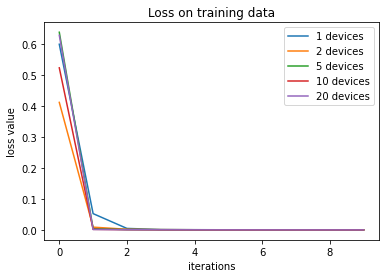

In [ ]:
plt.plot(loss1, label="1 devices")
plt.plot(loss2, label="2 devices")
plt.plot(loss5, label="5 devices")
plt.plot(loss10, label="10 devices")
plt.plot(loss20, label="20 devices")
plt.xlabel("iterations")
plt.ylabel("loss value")
plt.legend()
plt.title("Loss on training data")
plt.show()

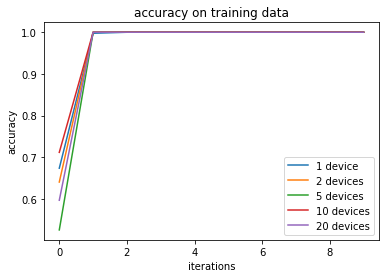

In [ ]:
plt.plot(accuracy1, label="1 device")
plt.plot(accuracy2, label="2 devices")
plt.plot(accuracy5, label="5 devices")
plt.plot(accuracy10, label="10 devices")
plt.plot(accuracy20, label="20 devices")
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.legend()
plt.title("accuracy on training data")
plt.show()

In [ ]:
print("Loss 1 :", loss1)
print("Loss 2 :", loss2)
print("Loss 5 :", loss5)
print("Loss 10 :", loss10)
print("Loss 20:", loss20)
print("-"*10)
print("Accuracy 1 : ", accuracy1)
print("Accuracy 2 : ", accuracy2)
print("Accuracy 5 : ", accuracy5)
print("Accuracy 10 : ", accuracy10)
print("Accuracy 20: ", accuracy20)

Loss 1 : [0.6004470266401768, 0.05277451081201434, 0.004924656264483929, 0.0014728306676261127, 0.0008070698415394873, 0.0005245895707048475, 0.00037701234978158025, 0.00029022292874287815, 0.00023438627540599554, 0.0001851463850471191]
Loss 2 : [0.41247919723391535, 0.00904716863296926, 0.0022497777827084064, 0.0011221055639907718, 0.0007078861002810299, 0.00048708352842368184, 0.00036640273756347594, 0.0002759399067144841, 0.00022912955901119859, 0.0001860461969044991]
Loss 5 : [0.6392642855644226, 0.004090693942271173, 0.0012029604869894684, 0.0006755763897672296, 0.00045362666714936494, 0.00033274953602813184, 0.0002503048483049497, 0.00019069837289862335, 0.00015373714559245854, 0.00013122787786414846]
Loss 10 : [0.5241808772087098, 0.0019527265802025795, 0.000904096697922796, 0.0005461182736326009, 0.00036720813950523733, 0.0002637360681546852, 0.00020655665430240332, 0.00016338531859219074, 0.00013199720997363328, 0.0001137670551543124]
Loss 20: [0.6294005334377288, 0.0014568839